In [15]:
import pandas as pd
from pandas import DataFrame
import os
import numpy as np
from numpy import setdiff1d
from numpy.random import choice, seed
import pickle
from copy import deepcopy
from shutil import move
import warnings
import random
from math import ceil
from time import time

import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'

import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.sparse import issparse
import scanpy as sc
from anndata import AnnData
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Lambda, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import exp as tf_exp, set_floatx
from tensorflow import convert_to_tensor as tensor
from tensorflow.keras.losses import KLD, MSE
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
from sklearn import metrics

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

In [3]:
def read_pancreas(path, cache=True):
    """A function to read and preprocess the pancreas data"""
    pathlist = os.listdir(path)[1:]
    #print(pathlist)
    adata = sc.read(os.path.join(path, pathlist[0]))
          
    for i in range(1,len(pathlist)):
        adata = adata.concatenate(sc.read(os.path.join(path, pathlist[i])))

    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 30)
    mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    notmito_genes = [not x for x in mito_genes]
    adata = adata[:,notmito_genes]
    del adata.obs['batch']
    print(adata)
    
    return adata

In [4]:
adata = read_pancreas("../Data/pancreas", cache=True)

filtered out 13148 genes that are detected in less than 30 cells
View of AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'
    var: 'genename', 'n_cells'


In [5]:
adata.obs['cell_type'] = adata.obs['celltype']

computing PCA
    with n_comps=50
    finished (0:00:34)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


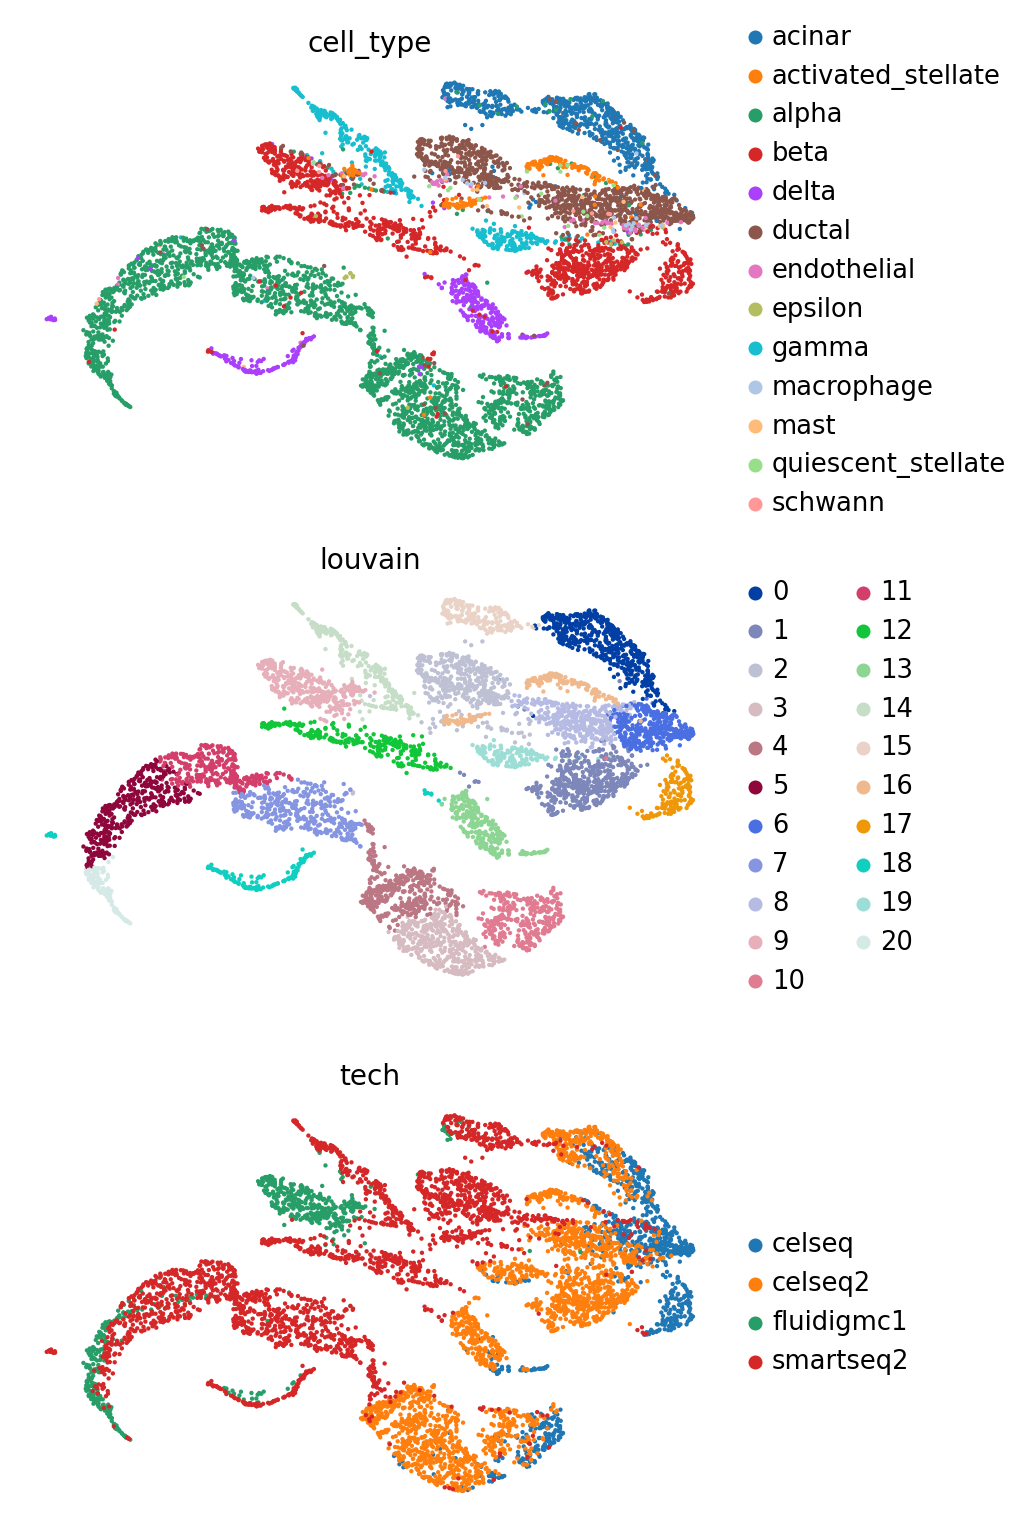

UMAP Results
ARI = 0.2869
NMI = 0.6025


In [7]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors = 15)
sc.tl.louvain(adata)

sc.tl.umap(adata)
adata.obs
sc.pl.umap(adata, color = ["cell_type","louvain", "tech"], return_fig = False, frameon=False, ncols=1, save='/1203_origin.pdf')

metrics_ = [ari, nmi]
ARI, NMI = [metric(adata.obs['cell_type'], adata.obs['louvain']) for metric in metrics_]

print("UMAP Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 

In [8]:
adata_test = adata.copy()

In [9]:
def preprocess(adata, tech_key, n_high_var = 1000, LVG = True):
    sparsemode = issparse(adata.X)
    tech = np.asarray(list(adata.obs[tech_key]))
    tech_list = np.unique(tech)
    
    sc.pp.normalize_total(adata, inplace = True)
    sc.pp.log1p(adata)
    
    sc.pp.highly_variable_genes(adata, inplace = True, n_top_genes = n_high_var, batch_key = tech_key)
    hvg = adata.var['highly_variable'].values
    
    if sparsemode:
        adata.X = adata.X.toarray()
            
    for tech_ in tech_list:
        indices = [x == tech_ for x in tech]
        sub_adata = adata[indices]  
        sc.pp.scale(sub_adata)
        adata[indices] = sub_adata.X
            
    adata.var['Variance Type'] = [['LVG', 'HVG'][int(x)] for x in hvg]
    
    del_keys = ['dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_intersection', 'highly_variable_nbatches', 'means']
    del_keys = [x for x in del_keys if x in adata.var.keys()]
    adata.var = adata.var.drop(del_keys, axis = 1)
    
    if not LVG:
        adata = adata[:, adata.var['Variance Type'] == 'HVG']
        
    return adata

In [10]:
preprocess(adata_test, 'tech')

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'louvain'
    var: 'genename', 'n_cells', 'Variance Type'
    uns: 'pca', 'neighbors', 'louvain', 'umap', 'cell_type_colors', 'louvain_colors', 'tech_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch): 
    lr = 1e-3 
    if epoch > 80:
        lr *= 0.5e-3
    elif epoch > 50:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 15: 
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule) 

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), 
                               cooldown=0, 
                               patience=5, 
                               min_lr=0.5e-6) 

earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0.05, 
                        patience=10, 
                        verbose=1, 
                        mode='min', 
                        restore_best_weights=True) 

callbacks = [earlystop, lr_reducer, lr_scheduler]

In [16]:
def pretrain(adata, random_state, LVG = False):
    random_state = 10
    X_train1, X_test1, y_denoise_train, y_denoise_test = train_test_split(adata.X[: , adata.var['Variance Type'] == 'HVG'], 
                                                                          adata.X[: , adata.var['Variance Type'] == 'HVG'], 
                                                                          random_state=random_state)
    if not LVG:
        n, p = adata.X[: , adata.var['Variance Type'] == 'HVG'].shape

        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

        input_gene = Input(shape = (p), dtype=float, name='input')

        x = Dense(128, kernel_initializer = 'glorot_uniform', 
                    activation = 'selu', name='encoder_1')(input_gene)
        encoded = Dense(32, kernel_initializer = 'glorot_uniform', 
                    activation = 'tanh', name='embedding')(x)

        x = Dense(128, kernel_initializer = 'glorot_uniform', 
                    activation = 'selu', name='decoder_1')(encoded)
        decoded = Dense(p, activation = 'linear', name='output')(x)

        autoencoder = Model(input_gene, decoded)
        encoder = Model(input_gene, encoded, name='encoder')
        decoder_input = Input(shape=(32,))
        decoder_layer = autoencoder.layers[-2](decoder_input)
        decoder_layer = autoencoder.layers[-1](decoder_layer)
        decoder = Model(decoder_input, decoder_layer, name='decoder')
        
        autoencoder.summary()
        
        autoencoder.compile(loss="mse", optimizer= Adam(), metrics=["mse"])
        
        autoencoder.fit(X_train1, y_denoise_train, validation_data=(X_test1, y_denoise_test),epochs=100, 
                        batch_size=128, shuffle=True, verbose=1, steps_per_epoch=1000, callbacks=callbacks)
        
        adata.obsm["pretransfer embedding"] = encoder.predict(adata.X[: , adata.var['Variance Type'] == 'HVG'])
        
        return autoencoder,decoder,encoder

In [17]:
ae_adata, decoder_adata, encoder_adata = pretrain(adata_test,10)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
encoder_1 (Dense)            (None, 128)               128128    
_________________________________________________________________
embedding (Dense)            (None, 32)                4128      
_________________________________________________________________
decoder_1 (Dense)            (None, 128)               4224      
_________________________________________________________________
output (Dense)               (None, 1000)              129000    
Total params: 265,480
Trainable params: 265,480
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
Learning rate:  0.001
1000/1000 [==============================] - 4s 3ms/step - loss: 0.6338 - mse: 0.6338 -

computing PCA
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


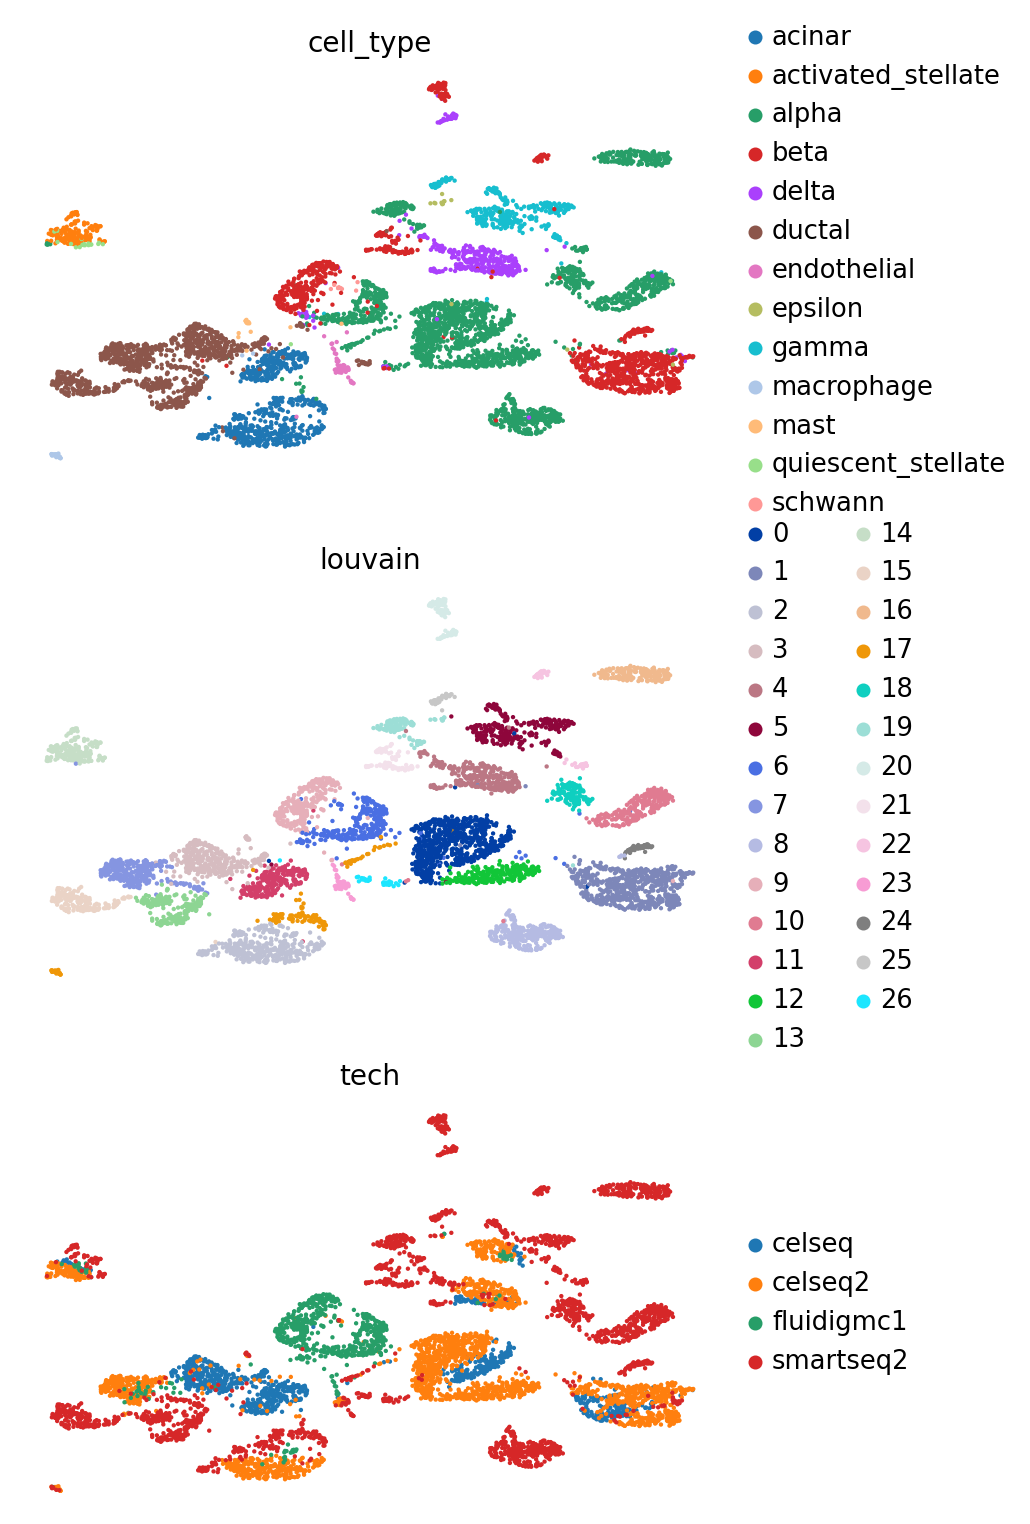

UMAP Results
ARI = 0.3240
NMI = 0.6516


In [18]:
sc.tl.pca(adata_test, svd_solver='arpack')
sc.pp.neighbors(adata_test, n_neighbors = 15)
sc.tl.louvain(adata_test)

sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color = ["cell_type","louvain", "tech"], return_fig = False, frameon=False, ncols=1, save='1203_processed.pdf')

ARI, NMI= [metric(adata_test.obs['cell_type'], adata_test.obs['louvain']) for metric in metrics_]

print("UMAP Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 

In [23]:
def multitask_model(adata, dataX, dataY, encoder, decoder, supervised = True, reconstruction = True, 
                    lossweight = [1, 1], reconstruction_loss = 'mse'):
    tf.keras.backend.clear_session()

    loss_monitor = 'loss'
    supervised_loss = tf.keras.losses.get('sparse_categorical_crossentropy')
    
    random_state = 10
    n, p = adata.X[: , adata.var['Variance Type'] == 'HVG'].shape

    random.seed(random_state)
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    input_gene = Input(shape = (p), dtype=float, name='input')

    x = Dense(128, kernel_initializer = 'glorot_uniform', 
                    activation = 'selu', name='encoder_1')(input_gene)
    encoded = Dense(32, kernel_initializer = 'glorot_uniform', 
                    activation = 'tanh', name='embedding')(x)
    encoder = Model(input_gene, encoded, name='encoder')
    
    Y = le.fit_transform(adata.obs['celltype']) 
    n_classes = len(np.unique(Y[Y != np.array(-1)]))

    supervised_output = Dense(n_classes, activation = 'softmax', name = 'supervised')(encoded)
    
    x = Dense(128, kernel_initializer = 'glorot_uniform', 
                    activation = 'selu', name='decoder_1')(encoded)
    reconstruction_output = Dense(p, activation = 'linear', name='decoder')(x)
    
    supervised_loss_weight = lossweight[0]
    reconstruction_loss_weight = lossweight[1]
    
    multitask_network = Model(inputs = input_gene, 
                              outputs = [supervised_output, reconstruction_output])

    multitask_network.summary()

    multitask_network.compile(loss = {'supervised': supervised_loss,'decoder': reconstruction_loss},
                            loss_weights = {'supervised': supervised_loss_weight,
                                            'decoder': reconstruction_loss_weight}, optimizer=Adam())
    multitask_network.fit(dataX, dataY, epochs=100, batch_size=128, shuffle=True, verbose=1, steps_per_epoch=1000)
    
    return multitask_network, encoder

In [24]:
adata_hvg = adata_test.X[: , adata_test.var['Variance Type'] == 'HVG']

In [25]:
data_X = np.array(adata_hvg)
data_Y = tuple([np.array(le.fit_transform(adata_test.obs['celltype'])), np.array(adata_hvg)])

In [26]:
multitask_network, encoder_renewed = multitask_model(adata_test, data_X, data_Y, encoder_adata, decoder_adata)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1000)]       0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 128)          128128      input[0][0]                      
__________________________________________________________________________________________________
embedding (Dense)               (None, 32)           4128        encoder_1[0][0]                  
__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 128)          4224        embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
adata_test.obsm["transferred embedding Y"] = encoder_renewed.predict(adata_test.X[: , adata_test.var['Variance Type'] == 'HVG'])
q = multitask_network.layers[-2](adata_test.obsm["transferred embedding Y"])
Labels = np.argmax(q, axis=1)
    
temporary = AnnData(adata_test.obsm["transferred embedding Y"])
temporary.obs = adata_test.obs
temporary.obs['cell_type'] = adata_test.obs['celltype']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

temporary.obs['supervised assignment'] = [str(x) for x in Labels]

sc.tl.umap(temporary)
# sc.pl.umap(temporary, color = ["cell_type", "supervised assignment", "tech"], return_fig = False, wspace = 0.25, size = 10, save=fig_name)
sc.pl.umap(temporary, color = ["cell_type", "supervised assignment", "tech"], return_fig = False, frameon=False, ncols=1, save='pancreas')

ARI, NMI = [metric(temporary.obs['cell_type'], temporary.obs['supervised assignment']) for metric in metrics_]


print("Supervised Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 

computing PCA
    with n_comps=31
    finished (0:00:00)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
